# Medical Image Fusion using Wavelet Transform

This notebook implements a traditional wavelet-based fusion approach for combining CT and MRI medical images. The method uses discrete wavelet transform (DWT) with various fusion rules to preserve complementary information from both modalities.

## Overview
- **CT Images**: Provide excellent bone and dense tissue visualization
- **MRI Images**: Offer superior soft tissue contrast
- **Fusion Goal**: Combine complementary information while preserving important details from both sources

## Key Features
- Multiple fusion strategies (max, average, weighted, activity-based)
- Support for different wavelet types (Haar, Daubechies, etc.)
- Quality metrics evaluation (MI, PSNR, edge preservation)
- Batch processing capabilities

## 1) Setup and Imports

This section sets up the environment and imports all necessary libraries for the wavelet-based medical image fusion implementation.

### Dependencies
- **PyTorch**: Deep learning framework for tensor operations and neural networks
- **OpenCV**: Computer vision library for image processing
- **NumPy**: Numerical computing library for array operations
- **Matplotlib**: Plotting library for visualization
- **PyTorch Wavelets**: Library for differentiable wavelet transforms

### Key Components
- Reproducibility setup with seed initialization
- Device configuration (CPU/GPU)
- Import of differentiable wavelet transform modules
- Standard scientific computing libraries

In [1]:
import os
import glob
from typing import Tuple, List

import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Differentiable wavelets
from pytorch_wavelets import DWTForward, DWTInverse

# Reproducibility
def seed_all(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 2) Dataset: Paired CT & MRI

This section defines a custom dataset class for loading paired CT and MRI images. The dataset ensures that corresponding images from both modalities are properly aligned and preprocessed.

### Folder Structure
```
data/
  ct/  image001.png, image002.png, ...
  mri/ image001.png, image002.png, ...  # same file names
```

### Features
- Automatic pairing of CT and MRI images by filename
- Support for multiple image formats
- Optional resizing and preprocessing
- Recursive directory scanning

In [2]:
class PairedMedicalFusionDataset(Dataset):
    """Paired dataset for registered CT & MRI images.
    - root_ct, root_mri: directories with identical filenames
    - resize: (H,W) or None
    - file_exts: accepted extensions
    """
    def __init__(self, root_ct: str, root_mri: str, resize: Tuple[int,int]=None,
                 file_exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
        self.root_ct = root_ct
        self.root_mri = root_mri
        self.resize = resize

        def index_dir(root):
            paths = []
            for ext in file_exts:
                paths.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
            base = {os.path.splitext(os.path.relpath(p, root))[0].replace('\\','/'): p for p in paths}
            return base

        base_ct = index_dir(root_ct)
        base_mr = index_dir(root_mri)
        self.keys = sorted(list(set(base_ct.keys()) & set(base_mr.keys())))
        if not self.keys:
            raise RuntimeError("No paired files found. Ensure matching filenames between CT and MRI.")
        self.base_ct = base_ct
        self.base_mr = base_mr

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        key = self.keys[idx]
        p_ct = self.base_ct[key]
        p_mr = self.base_mr[key]

        ct = cv2.imread(p_ct, cv2.IMREAD_GRAYSCALE)
        mr = cv2.imread(p_mr, cv2.IMREAD_GRAYSCALE)
        if ct is None or mr is None:
            raise FileNotFoundError(p_ct if ct is None else p_mr)
        if self.resize is not None:
            H, W = self.resize
            ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
            mr = cv2.resize(mr, (W, H), interpolation=cv2.INTER_AREA)

        ct = ct.astype(np.float32)
        mr = mr.astype(np.float32)
        if ct.max() > 1.0: ct /= 255.0
        if mr.max() > 1.0: mr /= 255.0

        ct_t = torch.from_numpy(ct)[None, ...]   # (1,H,W)
        mr_t = torch.from_numpy(mr)[None, ...]
        return ct_t, mr_t, key

## 3) Traditional Wavelet Fusion Model (Fixed Parameters)

This section implements the core wavelet-based fusion algorithm using discrete wavelet transform (DWT). The model applies fixed fusion rules based on established medical imaging literature.

### Fusion Strategies
- **Maximum Selection**: Choose coefficients with larger absolute values
- **Simple Averaging**: Average corresponding coefficients
- **Weighted Average**: Use predefined weights (CT=0.6, MRI=0.4 for low frequency)
- **Activity-Based**: Select coefficients based on local variance/activity measures

### Key Components
- One-level discrete wavelet transform
- Multiple wavelet types support (Haar, Daubechies, etc.)
- Separate processing for low-frequency (approximation) and high-frequency (detail) components

In [3]:
class TraditionalWaveletFusion(nn.Module):
    def __init__(self, wave: str = 'haar', fusion_method: str = 'max'):
        """
        Traditional wavelet fusion with fixed parameters.
        
        Args:
            wave: Wavelet type ('haar', 'db4', 'biorthogonal', etc.)
            fusion_method: Fusion strategy
                - 'max': Maximum selection rule
                - 'average': Simple averaging
                - 'weighted': Weighted average (CT=0.6, MRI=0.4 for low freq)
                - 'activity': Activity measure based fusion
        """
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)   # one-level DWT
        self.idwt = DWTInverse(wave=wave)
        self.fusion_method = fusion_method
        
        # Fixed fusion weights for medical images (based on literature)
        # CT typically better for bone/dense structures, MRI for soft tissue
        self.alpha_low = 0.6   # CT weight for low-frequency (approximation)
        self.alpha_high = 0.5  # Balanced for high-frequency details
        
        print(f"Using {fusion_method} fusion with {wave} wavelets")

    def _max_fusion(self, ct_band, mr_band):
        """Maximum selection rule - choose coefficient with larger absolute value"""
        ct_abs = torch.abs(ct_band)
        mr_abs = torch.abs(mr_band)
        mask = ct_abs >= mr_abs
        return torch.where(mask, ct_band, mr_band)

    def _average_fusion(self, ct_band, mr_band):
        """Simple averaging"""
        return 0.5 * (ct_band + mr_band)

    def _weighted_fusion(self, ct_band, mr_band, weight):
        """Weighted averaging with fixed weights"""
        return weight * ct_band + (1.0 - weight) * mr_band

    def _activity_fusion(self, ct_band, mr_band, window_size=3):
        """Activity measure based fusion using local variance"""
        def local_variance(x):
            # Compute local variance using unfold
            # Expecting x shape: (B, C, H, W)
            if x.dim() == 5:
                # If orientation axis present (B,C,orient,H,W) collapse orient into channel
                B, C, O, H, W = x.shape
                x = x.view(B, C * O, H, W)
            B, C, H, W = x.shape
            pad = window_size // 2
            x_pad = F.pad(x, (pad, pad, pad, pad), mode='reflect')
            patches = x_pad.unfold(2, window_size, 1).unfold(3, window_size, 1)
            # patches: (B, C, H, W, window_size, window_size)
            patches_flat = patches.contiguous().view(B, C, H, W, -1)
            variance = torch.var(patches_flat, dim=-1, keepdim=False)
            return variance

        # Ensure bands are (B,C,H,W)
        if ct_band.dim() == 5:
            ct_band_proc = ct_band.view(ct_band.size(0), ct_band.size(1) * ct_band.size(2), ct_band.size(3), ct_band.size(4))
        else:
            ct_band_proc = ct_band
        if mr_band.dim() == 5:
            mr_band_proc = mr_band.view(mr_band.size(0), mr_band.size(1) * mr_band.size(2), mr_band.size(3), mr_band.size(4))
        else:
            mr_band_proc = mr_band

        ct_activity = local_variance(ct_band_proc)
        mr_activity = local_variance(mr_band_proc)

        # Choose coefficient from source with higher activity (element-wise)
        mask = ct_activity >= mr_activity
        # mask shape: (B, C, H, W) -> need to broadcast to band shape
        return torch.where(mask, ct_band_proc, mr_band_proc)

    def forward(self, ct, mr):
        # Inputs: (B,1,H,W) in [0,1]
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)
        
        # ct_high[0]: (B, C, 3, H/2, W/2) order = (LH, HL, HH)
        # Extract orientation axis (3) into separate bands -> tensors shape (B, C, H/2, W/2)
        ct_lh = ct_high[0][:, :, 0, :, :]
        ct_hl = ct_high[0][:, :, 1, :, :]
        ct_hh = ct_high[0][:, :, 2, :, :]
        mr_lh = mr_high[0][:, :, 0, :, :]
        mr_hl = mr_high[0][:, :, 1, :, :]
        mr_hh = mr_high[0][:, :, 2, :, :]

        # Fusion rules for different frequency bands
        if self.fusion_method == 'max':
            # Low frequency: weighted average (preserve overall contrast)
            fused_low = self._weighted_fusion(ct_low, mr_low, self.alpha_low)
            # High frequency: maximum selection (preserve details)
            fused_lh = self._max_fusion(ct_lh, mr_lh)
            fused_hl = self._max_fusion(ct_hl, mr_hl)
            fused_hh = self._max_fusion(ct_hh, mr_hh)
            
        elif self.fusion_method == 'average':
            fused_low = self._average_fusion(ct_low, mr_low)
            fused_lh = self._average_fusion(ct_lh, mr_lh)
            fused_hl = self._average_fusion(ct_hl, mr_hl)
            fused_hh = self._average_fusion(ct_hh, mr_hh)
            
        elif self.fusion_method == 'weighted':
            fused_low = self._weighted_fusion(ct_low, mr_low, self.alpha_low)
            fused_lh = self._weighted_fusion(ct_lh, mr_lh, self.alpha_high)
            fused_hl = self._weighted_fusion(ct_hl, mr_hl, self.alpha_high)
            fused_hh = self._weighted_fusion(ct_hh, mr_hh, self.alpha_high)
            
        elif self.fusion_method == 'activity':
            # Low frequency: weighted average
            fused_low = self._weighted_fusion(ct_low, mr_low, self.alpha_low)
            # High frequency: activity-based selection
            fused_lh = self._activity_fusion(ct_lh, mr_lh)
            fused_hl = self._activity_fusion(ct_hl, mr_hl)
            fused_hh = self._activity_fusion(ct_hh, mr_hh)
        
        else:
            raise ValueError(f"Unknown fusion method: {self.fusion_method}")

        # Reconstruct fused image
        # Stack along orientation axis to match DWTInverse expected shape (B, C, 3, h, w)
        fused_high = torch.stack([fused_lh, fused_hl, fused_hh], dim=2)  # (B,C,3,h,w)
        fused = self.idwt((fused_low, [fused_high]))
        return fused


## 4) Fusion Quality Metrics (for evaluation)

This section implements quantitative evaluation metrics to assess the quality of fused medical images. These metrics help determine how well the fusion process preserves information from both source images.

### Implemented Metrics
- **Mutual Information (MI)**: Measures information preservation from source images
- **Peak Signal-to-Noise Ratio (PSNR)**: Evaluates reconstruction quality
- **Standard Deviation (STD)**: Measures information content/variation
- **Edge Variance**: Assesses edge preservation using Sobel operator

### Usage
These metrics are calculated for each fused image and can be used to:
- Compare different fusion methods
- Evaluate fusion quality objectively
- Monitor the effectiveness of the fusion process

In [4]:

def calculate_fusion_metrics(fused, ct, mr):
    """Calculate common fusion quality metrics"""
    # Convert to numpy for easier calculation
    fused_np = fused.detach().cpu().numpy().squeeze()
    ct_np = ct.detach().cpu().numpy().squeeze()
    mr_np = mr.detach().cpu().numpy().squeeze()
    
    metrics = {}
    
    # 1. Mutual Information (simplified)
    def mutual_info(x, y):
        hist, _, _ = np.histogram2d(x.flatten(), y.flatten(), bins=50)
        hist_norm = hist / hist.sum()
        # Add small epsilon to avoid log(0)
        hist_norm = hist_norm + 1e-10
        
        # Marginal distributions
        px = hist_norm.sum(axis=1)
        py = hist_norm.sum(axis=0)
        
        mi = 0
        for i in range(len(px)):
            for j in range(len(py)):
                if hist_norm[i,j] > 0:
                    mi += hist_norm[i,j] * np.log2(hist_norm[i,j] / (px[i] * py[j]))
        return mi
    
    metrics['MI_CT'] = mutual_info(fused_np, ct_np)
    metrics['MI_MRI'] = mutual_info(fused_np, mr_np)
    
    # 2. Peak Signal-to-Noise Ratio (reference = average of sources)
    ref = 0.5 * (ct_np + mr_np)
    mse = np.mean((fused_np - ref) ** 2)
    if mse > 0:
        metrics['PSNR'] = 20 * np.log10(1.0 / np.sqrt(mse))
    else:
        metrics['PSNR'] = float('inf')
    
    # 3. Standard Deviation (information content)
    metrics['STD'] = np.std(fused_np)
    
    # 4. Edge preservation
    def sobel_variance(img):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        return np.var(np.sqrt(sobelx**2 + sobely**2))
    
    metrics['Edge_Variance'] = sobel_variance(fused_np)
    
    return metrics

## 5) Demonstration and Evaluation

This section provides a complete demonstration of the wavelet fusion pipeline, including:
- Configuration setup for the fusion process
- Dataset loading and preparation
- Model initialization with specified parameters
- Batch processing of image pairs
- Quality metrics calculation and analysis

### Configuration Parameters
- **Data Directories**: Paths to CT and MRI image folders
- **Output Directory**: Where fused results will be saved
- **Image Processing**: Optional resizing and preprocessing options
- **Fusion Settings**: Wavelet type and fusion method selection

### Workflow
1. Load and configure the dataset
2. Initialize the fusion model
3. Process images in batches
4. Calculate quality metrics
5. Save results for analysis

In [5]:
from dataclasses import dataclass

@dataclass
class Config:
    ct_dir: str = 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT'
    mri_dir: str = 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI'
    output_dir: str = 'fusion_results'
    resize: Tuple[int,int] = None  # e.g., (256,256)
    wave: str = 'haar'  # 'haar', 'db4', 'biorthogonal'
    fusion_method: str = 'max'  # 'max', 'average', 'weighted', 'activity'

cfg = Config()
print(cfg)

# %%
# Build dataset
os.makedirs(cfg.output_dir, exist_ok=True)

dset = PairedMedicalFusionDataset(cfg.ct_dir, cfg.mri_dir, resize=cfg.resize)
print(f"Dataset size: {len(dset)} pairs")

# Initialize fusion model
fusion_model = TraditionalWaveletFusion(wave=cfg.wave, fusion_method=cfg.fusion_method).to(device)
print(f"Fusion parameters: Low-freq weight={fusion_model.alpha_low}, High-freq weight={fusion_model.alpha_high}")

Config(ct_dir='Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT', mri_dir='Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI', output_dir='fusion_results', resize=None, wave='haar', fusion_method='max')
Dataset size: 160 pairs
Using max fusion with haar wavelets
Fusion parameters: Low-freq weight=0.6, High-freq weight=0.5


## 6) Process Images and Evaluate

This section contains the core processing pipeline that applies the wavelet fusion model to the dataset and evaluates the results.

### Batch Processing Function
The `process_dataset` function handles:
- Model evaluation mode setup
- Batch processing of image pairs
- Quality metrics calculation for each fused image
- Automatic saving of results to disk
- Progress tracking and status updates

### Key Features
- Memory-efficient processing with `@torch.no_grad()`
- Configurable sample limits for testing
- Comprehensive metrics collection
- Automatic result saving with descriptive filenames

In [6]:
@torch.no_grad()
def process_dataset(model, dataset, max_samples=None):
    """Process dataset and compute metrics"""
    model.eval()
    all_metrics = []
    
    num_samples = min(len(dataset), max_samples) if max_samples else len(dataset)
    
    for i in range(num_samples):
        ct, mr, key = dataset[i]
        
        # Add batch dimension and move to device
        ct_batch = ct.unsqueeze(0).to(device)
        mr_batch = mr.unsqueeze(0).to(device)
        
        # Fuse images
        fused_batch = model(ct_batch, mr_batch)
        
        # Calculate metrics
        metrics = calculate_fusion_metrics(fused_batch[0], ct_batch[0], mr_batch[0])
        metrics['image_key'] = key
        all_metrics.append(metrics)
        
        # Save fused result
        fused_np = fused_batch[0, 0].clamp(0, 1).cpu().numpy()
        fused_uint8 = (fused_np * 255).astype(np.uint8)
        
        output_path = os.path.join(cfg.output_dir, f"{key.replace('/', '_')}_fused_{cfg.fusion_method}.png")
        cv2.imwrite(output_path, fused_uint8)
        
        if i % 10 == 0:
            print(f"Processed {i+1}/{num_samples}: {key}")
    
    return all_metrics

# Process a subset of images for demonstration
print("Processing images...")
metrics_results = process_dataset(fusion_model, dset, max_samples=20)

Processing images...
Processed 1/20: 16003
Processed 11/20: 16020


## 7) Results Analysis and Visualization

This section provides comprehensive analysis and visualization of the fusion results, including:
- Statistical summary of quality metrics across all processed images
- Visual comparison of different fusion methods
- Side-by-side display of original and fused images

### Analysis Components
- **Metrics Summary**: Mean and standard deviation of all quality metrics
- **Method Comparison**: Visual comparison of different fusion approaches
- **Sample Visualization**: Detailed examination of individual fusion results

### Visualization Functions
- `show_fusion_comparison()`: Creates comparison plots of different fusion methods
- Automatic subplot arrangement based on number of methods
- Professional matplotlib-based visualization with proper titles and layout


Fusion Quality Metrics Summary:
MI_CT          : Mean=1.2186, Std=0.1093
MI_MRI         : Mean=1.0867, Std=0.1145
PSNR           : Mean=26.2169, Std=1.5704
STD            : Mean=0.2614, Std=0.0244
Edge_Variance  : Mean=0.2797, Std=0.0824

Comparing fusion methods on sample: 16003
Using max fusion with haar wavelets
max       : MI_CT=1.058, MI_MRI=1.057, PSNR=26.08
Using average fusion with haar wavelets
average   : MI_CT=1.081, MI_MRI=1.722, PSNR=85.20
Using weighted fusion with haar wavelets
weighted  : MI_CT=1.149, MI_MRI=1.447, PSNR=29.77
Using activity fusion with haar wavelets
activity  : MI_CT=1.067, MI_MRI=1.052, PSNR=26.08


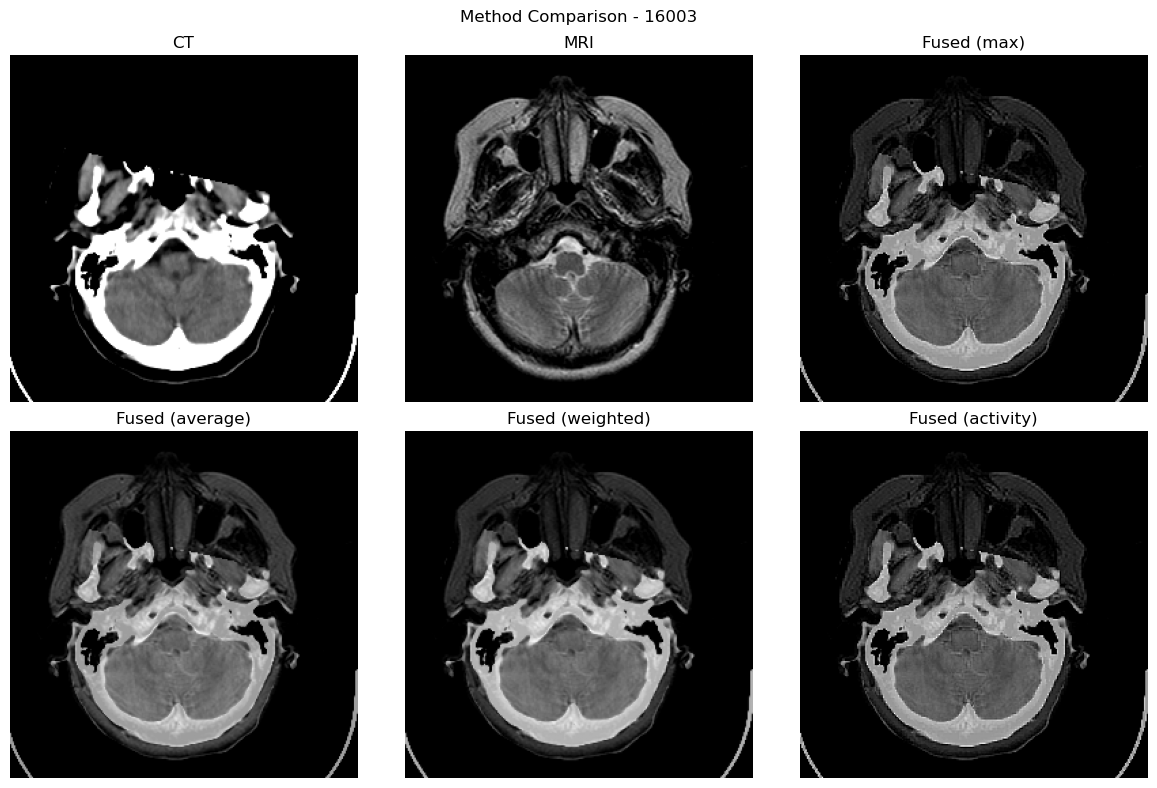

In [7]:
# Analyze metrics
import pandas as pd

df_metrics = pd.DataFrame(metrics_results)
print("\nFusion Quality Metrics Summary:")
print("="*50)
for col in ['MI_CT', 'MI_MRI', 'PSNR', 'STD', 'Edge_Variance']:
    if col in df_metrics.columns:
        print(f"{col:15s}: Mean={df_metrics[col].mean():.4f}, Std={df_metrics[col].std():.4f}")

# %%
@torch.no_grad()
def show_fusion_comparison(ct, mr, fused_dict, title="Fusion Comparison"):
    """Show comparison of different fusion methods"""
    n_methods = len(fused_dict) + 2  # +2 for original CT and MRI
    fig, axes = plt.subplots(2, (n_methods + 1) // 2, figsize=(4 * ((n_methods + 1) // 2), 8))
    axes = axes.flatten() if n_methods > 2 else [axes] if n_methods == 1 else axes
    
    # Original images
    ct_np = ct.detach().cpu().clamp(0,1)[0,0].numpy()
    mr_np = mr.detach().cpu().clamp(0,1)[0,0].numpy()
    
    axes[0].imshow(ct_np, cmap='gray')
    axes[0].set_title('CT')
    axes[0].axis('off')
    
    axes[1].imshow(mr_np, cmap='gray')
    axes[1].set_title('MRI')
    axes[1].axis('off')
    
    # Fused images
    for i, (method, fused) in enumerate(fused_dict.items(), 2):
        fused_np = fused.detach().cpu().clamp(0,1)[0,0].numpy()
        axes[i].imshow(fused_np, cmap='gray')
        axes[i].set_title(f'Fused ({method})')
        axes[i].axis('off')
    
    # Hide unused axes
    for j in range(len(fused_dict) + 2, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# %%
# Compare different fusion methods on a sample
if len(dset) > 0:
    sample_idx = 0
    ct_sample, mr_sample, key_sample = dset[sample_idx]
    ct_batch = ct_sample.unsqueeze(0).to(device)
    mr_batch = mr_sample.unsqueeze(0).to(device)
    
    fusion_methods = ['max', 'average', 'weighted', 'activity']
    fused_results = {}
    
    print(f"\nComparing fusion methods on sample: {key_sample}")
    
    for method in fusion_methods:
        model = TraditionalWaveletFusion(wave=cfg.wave, fusion_method=method).to(device)
        model.eval()
        with torch.no_grad():
            fused = model(ct_batch, mr_batch)
            fused_results[method] = fused
            
            # Calculate metrics for this method
            metrics = calculate_fusion_metrics(fused[0], ct_batch[0], mr_batch[0])
            print(f"{method:10s}: MI_CT={metrics['MI_CT']:.3f}, MI_MRI={metrics['MI_MRI']:.3f}, PSNR={metrics['PSNR']:.2f}")
    
    # Show visual comparison
    show_fusion_comparison(ct_batch, mr_batch, fused_results, f"Method Comparison - {key_sample}")

## 8) Inference Helpers

This section provides convenient utility functions for applying the wavelet fusion model to new data without going through the full training pipeline.

### Available Functions

#### `fuse_pair()`
- **Purpose**: Fuse a single pair of CT and MRI images
- **Inputs**: File paths to CT and MRI images
- **Outputs**: Fused image as numpy array
- **Features**: Automatic preprocessing, model initialization, and postprocessing

#### `fuse_folder()`
- **Purpose**: Batch process entire folders of paired images
- **Inputs**: Source directories for CT and MRI images, output directory
- **Features**: Progress tracking, automatic pairing by filename, batch processing

### Key Features
- Memory-efficient inference with `@torch.no_grad()`
- Flexible parameter configuration
- Automatic file handling and error checking
- Support for various image formats and preprocessing options

In [8]:





@torch.no_grad()
def fuse_pair(ct_path: str, mr_path: str, wave: str = 'haar', 
              fusion_method: str = 'max', resize: Tuple[int,int] = None, device=device) -> np.ndarray:
    """Fuse a single CT-MRI pair"""
    
    # Load images
    ct_img = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
    mr_img = cv2.imread(mr_path, cv2.IMREAD_GRAYSCALE)
    
    if ct_img is None or mr_img is None:
        raise FileNotFoundError(f"Could not load images: {ct_path}, {mr_path}")
    
    # Preprocess
    if resize is not None:
        H, W = resize
        ct_img = cv2.resize(ct_img, (W, H), interpolation=cv2.INTER_AREA)
        mr_img = cv2.resize(mr_img, (W, H), interpolation=cv2.INTER_AREA)
    
    ct_img = ct_img.astype(np.float32) / 255.0
    mr_img = mr_img.astype(np.float32) / 255.0
    
    # Convert to tensors
    ct_tensor = torch.from_numpy(ct_img)[None, None].to(device)
    mr_tensor = torch.from_numpy(mr_img)[None, None].to(device)
    
    # Initialize model and fuse
    model = TraditionalWaveletFusion(wave=wave, fusion_method=fusion_method).to(device)
    model.eval()
    
    fused_tensor = model(ct_tensor, mr_tensor)
    fused_np = fused_tensor.clamp(0, 1)[0, 0].cpu().numpy()
    fused_uint8 = (fused_np * 255.0).astype(np.uint8)
    
    return fused_uint8

# %%
@torch.no_grad()
def fuse_folder(ct_dir: str, mr_dir: str, output_dir: str, 
                wave: str = 'haar', fusion_method: str = 'max', 
                resize: Tuple[int,int] = None):
    """Fuse all pairs in two folders"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Create dataset
    dataset = PairedMedicalFusionDataset(ct_dir, mr_dir, resize=resize)
    
    # Initialize model
    model = TraditionalWaveletFusion(wave=wave, fusion_method=fusion_method).to(device)
    model.eval()
    
    print(f"Fusing {len(dataset)} pairs using {fusion_method} method with {wave} wavelets...")
    
    for i in range(len(dataset)):
        ct, mr, key = dataset[i]
        
        # Add batch dimension and move to device
        ct_batch = ct.unsqueeze(0).to(device)
        mr_batch = mr.unsqueeze(0).to(device)
        
        # Fuse
        fused_batch = model(ct_batch, mr_batch)
        fused_np = fused_batch[0, 0].clamp(0, 1).cpu().numpy()
        fused_uint8 = (fused_np * 255).astype(np.uint8)
        
        # Save
        output_filename = f"{key.replace('/', '_')}_fused_{fusion_method}.png"
        output_path = os.path.join(output_dir, output_filename)
        cv2.imwrite(output_path, fused_uint8)
        
        if i % 10 == 0:
            print(f"Processed {i+1}/{len(dataset)}")
    
    print(f"Fusion complete! Results saved to: {output_dir}")



## 9) Usage Examples

This section provides practical examples of how to use the wavelet fusion implementation for different scenarios.

### Example 1: Batch Processing Folders
```python
# Fuse entire folders of images
fuse_folder(
    ct_dir='path/to/ct/images',
    mr_dir='path/to/mri/images',
    output_dir='fused_results',
    wave='db4',                    # Use Daubechies-4 wavelet
    fusion_method='activity',      # Activity-based fusion
    resize=(256, 256)             # Resize to 256x256
)
```

### Example 2: Single Image Pair
```python
# Fuse individual image pair
fused_img = fuse_pair(
    ct_path='ct_image.png',
    mr_path='mri_image.png',
    fusion_method='max'           # Maximum selection rule
)
cv2.imwrite('fused_output.png', fused_img)
```

### Available Fusion Methods
- **'max'**: Maximum selection (recommended for medical images)
- **'average'**: Simple averaging (smooth results)
- **'weighted'**: Fixed weighted average (CT=0.6, MRI=0.4 for low frequency)
- **'activity'**: Activity measure based selection (preserves local features)

### Recommended Settings
- **Medical Images**: Use 'max' method to preserve both bone (CT) and soft tissue (MRI) details
- **Wavelet Type**: 'haar' for speed, 'db4' for quality
- **Image Size**: 256x256 or 512x512 for optimal processing

In [9]:
# Example 1: Fuse entire folder
# fuse_folder(
#     ct_dir='path/to/ct/images',
#     mr_dir='path/to/mri/images', 
#     output_dir='fused_results',
#     wave='db4',
#     fusion_method='activity',
#     resize=(256, 256)
# )

# Example 2: Fuse single pair
# fused_img = fuse_pair(
#     ct_path='ct_image.png',
#     mr_path='mri_image.png',
#     fusion_method='max'
# )
# cv2.imwrite('fused_output.png', fused_img)

print("Traditional wavelet fusion implementation complete!")
print("\nAvailable fusion methods:")
print("- 'max': Maximum selection (good for preserving details)")
print("- 'average': Simple averaging (smooth results)")  
print("- 'weighted': Fixed weighted average (CT=0.6, MRI=0.4 for low freq)")
print("- 'activity': Activity measure based selection (preserves local features)")
print("\nRecommended: 'max' for medical images to preserve both bone (CT) and soft tissue (MRI) details.")

# %%

Traditional wavelet fusion implementation complete!

Available fusion methods:
- 'max': Maximum selection (good for preserving details)
- 'average': Simple averaging (smooth results)
- 'weighted': Fixed weighted average (CT=0.6, MRI=0.4 for low freq)
- 'activity': Activity measure based selection (preserves local features)

Recommended: 'max' for medical images to preserve both bone (CT) and soft tissue (MRI) details.
